# DLRM - tensorflow Model 
------------------------------
- DLRM paper : Deep Learning Recommendation Model for Personalization and Recommendation Systems https://arxiv.org/abs/1906.00091 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import logging
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Custome LabelEncoding Class 
from src.utils import LabelEncoding
from src.model import DLRMModel

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

In [7]:
tf.__version__

'2.4.1'

Check the device information

In [8]:
device_name = tf.test.gpu_device_name()

In [9]:
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


### Load Adult data set to predict the income over 50k

In [10]:
data = pd.read_csv('./data/adult.csv')

In [11]:
data.shape

(48842, 15)

In [12]:
data.head(2)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K


### Set the numercal features and categorical features 

In [13]:
all_columns = data.columns

In [14]:
num_cols = ['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


In [15]:
cat_cols = list(set(all_columns)-set(num_cols))

In [16]:
target_cols = ['income']

In [17]:
print (num_cols)
print (cat_cols)
print (target_cols)

['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
['age', 'gender', 'occupation', 'race', 'relationship', 'native-country', 'marital-status', 'education', 'workclass', 'educational-num', 'income']
['income']


## Set Data 
#### LabelEncoding of categorical features
#### MinMaxSclae of numerical features

In [18]:
num_data = data[num_cols]
cat_data = data[cat_cols]
target = data[target_cols]

In [19]:
target[target_cols] = (target[target_cols]=='>50K').astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [20]:
scaler = MinMaxScaler()
num_data_scaled = scaler.fit_transform(num_data)

In [21]:
lbenc = LabelEncoding()

In [22]:
lbenc.fit(cat_data, cat_data.columns)

In [23]:
cat_enc = lbenc.transform(cat_data)

In [24]:
cat_enc.head(2)

,age,gender,occupation,race,relationship,native-country,marital-status,education,workclass,educational-num,income
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,0,1,1,0,1,0


# Model Architecture
----------------

#### 1) Numerical Value (whole input)
- 512, 256, 16 with Relu
#### 2) Categorical Value 
- embedding 16 for each input categori


#### 3) Make 2nd order inner product layer 

#### 4) concatenate all the output from the 2nd order term and numerical values

#### 5) Classification Layer 
- input : 16 * feature_num 
- 512, 256, 1 (sigmoid) 


![Model Architecture](./img/model.png)

### Prepare training datasets 
- X, y

In [29]:
y = target[target_cols].values

In [30]:
X = [num_data.values]

In [31]:
cat_x = []
for col in cat_enc:
    cat_x.append(cat_enc[col].values)

In [32]:
X.append(cat_x)

Set categorical features information

In [33]:
feature_dic = {}
for col in cat_enc:
    feature_dic[col] = cat_enc[col].nunique()

### Fitting model

In [35]:
dlrm = DLRMModel(num_data, cat_enc, feature_dic)

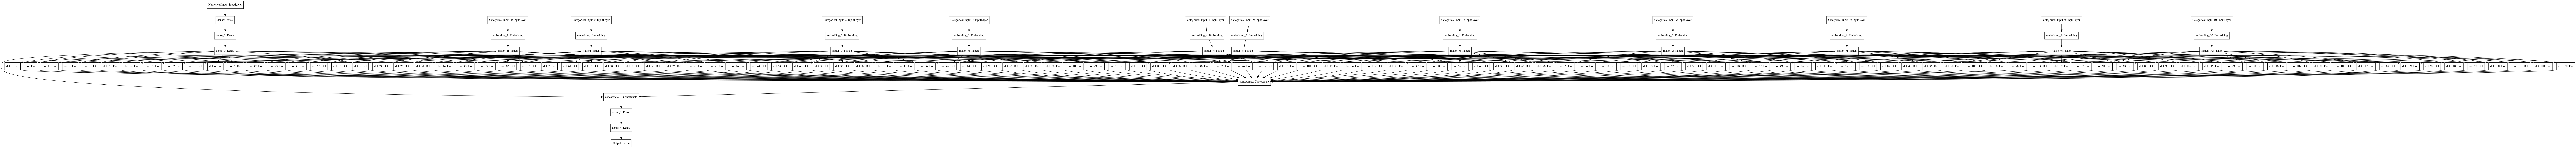

In [36]:
plot_model(dlrm)

In [37]:
dlrm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
dlrm.fit(X, y, epochs=2)

Epoch 1/2
1527/1527 [==============================] - 21s 10ms/step - loss: 12.1528 - accuracy: 0.9539
Epoch 2/2
1527/1527 [==============================] - 15s 10ms/step - loss: 7.9507e-07 - accuracy: 1.0000
